In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (204).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (387).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (221).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (415).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (467).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (463).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (335).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (37).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (244).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (125).jpg
/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal/val_normal_ (436).jpg
/kaggle/input/curated-

In [2]:
import torch
import os
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50
from matplotlib import image
from matplotlib import pyplot
import time

In [3]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  train_transform=transforms.Compose([transforms.Resize(inp_size), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  val_transform = transforms.Compose([transforms.Resize(inp_size), transforms.ToTensor(), normalize])
  train_data = datasets.ImageFolder(root=path+"/train", transform=train_transform)
  val_data = datasets.ImageFolder(root=path+"/val",transform=val_transform)
  test_data = datasets.ImageFolder(root=path+"/test",transform=val_transform)
  print(val_data)
  # test_split = round((1-train_split-val_split), 2)
  # print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  data_length = len(val_data)
  # The no. of images in each split of train, val and test
  train_size = int(0.3*data_length)
  val_size = int(0.6*data_length)
  test_size = data_length - val_size - train_size
  val_data, _, _ = td.random_split(val_data, [train_size, val_size, 
                                                    test_size])
  
  print(len(val_data))
  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader

In [4]:
# Initialize the data loaders through the image_preprocess function
path = "/kaggle/input/curated-colon-dataset-for-deep-learning/"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224, 224))


Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /kaggle/input/curated-colon-dataset-for-deep-learning//val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
600


In [5]:
# Loader data plotted for visualizaion
def plot_data_loader(loader, grid):
  fig, axes = plt.subplots(nrows=grid[0], ncols=grid[1], figsize=(6,6))
  dataiter = iter(loader)
  for i in range(grid[0]):
    for j in range(grid[1]):
      images, _ = dataiter.next()
      axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

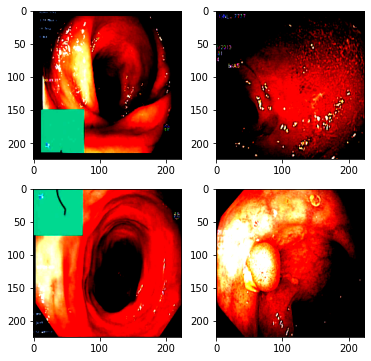

In [6]:
plot_data_loader(train_loader, [2,2])

In [7]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=10):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):
      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, train_accuracy_list, val_accuracy_list, best_accuracy

In [8]:
# Model definition and initialization
model = resnet50()
num_ftrs = model.fc.in_features
path =  "/kaggle/input/curated-colon-dataset-for-deep-learning"
classes = os.listdir(path+"/train")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [9]:
best_model, training_accuracy_list, val_accuracy_list, best_accuracy = train_model(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, lossFunc=loss, epochs=20)

Device: cuda:0
Epoch [1/20], Train_Loss: 1.6240, Train_Accuracy: 21.88%  Val_Loss: 2.5056, Val_Accuracy: 45.83%
Epoch [1/20], Train_Loss: 2.2237, Train_Accuracy: 34.38%  Val_Loss: 1.6545, Val_Accuracy: 54.17%
Epoch [1/20], Train_Loss: 2.4173, Train_Accuracy: 40.62%  Val_Loss: 1.1393, Val_Accuracy: 45.83%
Epoch [1/20], Train_Loss: 1.1022, Train_Accuracy: 62.50%  Val_Loss: 1.2937, Val_Accuracy: 58.33%
Epoch [1/20], Train_Loss: 1.2163, Train_Accuracy: 65.62%  Val_Loss: 0.8502, Val_Accuracy: 79.17%
Epoch [1/20], Train_Loss: 1.2565, Train_Accuracy: 56.25%  Val_Loss: 1.2837, Val_Accuracy: 70.83%
Epoch [1/20], Train_Loss: 1.0672, Train_Accuracy: 65.62%  Val_Loss: 0.8681, Val_Accuracy: 75.00%
Epoch [1/20], Train_Loss: 0.4495, Train_Accuracy: 75.00%  Val_Loss: 0.5748, Val_Accuracy: 83.33%
Epoch [1/20], Train_Loss: 0.5264, Train_Accuracy: 78.12%  Val_Loss: 0.7124, Val_Accuracy: 66.67%
Epoch [1/20], Train_Loss: 0.7098, Train_Accuracy: 78.12%  Val_Loss: 0.6075, Val_Accuracy: 70.83%
Epoch [1/20], T

In [10]:
resNet_fourclass = {'model': best_model,
               'training_accuracy_list': training_accuracy_list,
               'val_accuracy_list': val_accuracy_list,
              'state_dict': best_model.state_dict()}
torch.save(resNet_fourclass, '/kaggle/working/resNet_fourclass.pth')

In [33]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(20,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.ylim([0,100])
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [24]:
len(training_accuracy_list)

2000

In [16]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%100==0):
            accuracy.append(sum/100)
            sum = 0
        else: 
            sum += v

    return accuracy

In [26]:
len(train_accuracy)

20

In [25]:
train_accuracy, val_accuracy = accuracyForEachEpoch(training_accuracy_list), accuracyForEachEpoch(val_accuracy_list)

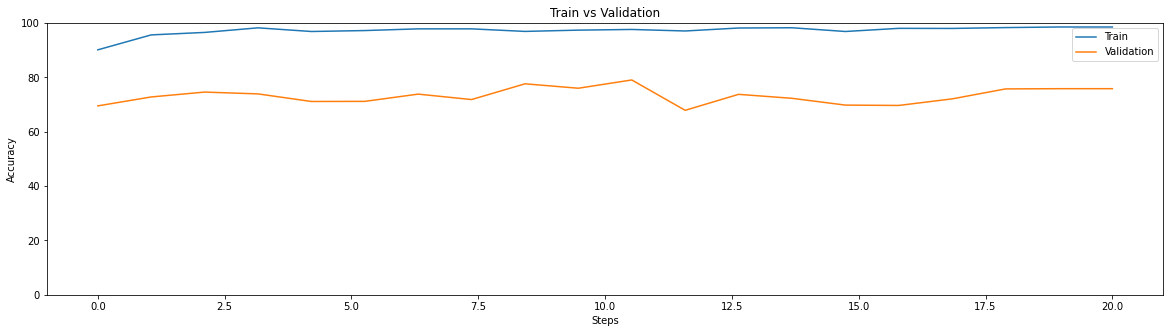

In [34]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader))

In [35]:
best_model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = best_model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 800 test images: 78.25 %
